In this notebook we will process the synthetic Austen/food reviews data and convert it into feature vectors. In later notebooks these feature vectors will be the inputs to models which we will train and eventually use to identify spam. 

This notebook uses term frequency-inverse document frequency, or Tf-idf, to generate feature vectors. Tf-idf is commonly used to summarise text data, and it aims to capture how important different words are within a set of document. Tf-idf combines word count, or term frequency, with the inverse document frequency in order to identify words, or terms, which are 'interesting' or important within the document. 


We begin by loading in the data:

In [1]:
import pandas as pd

df = pd.read_parquet("data/training.parquet")

To illustrate the computation of tf-idf vectors we will first implement the method on a sample of three of the documents we just loaded.   

In [2]:
import numpy as np

np.random.seed(0xc0ffeeee)
df_samp = df.sample(3)

In [3]:
pd.set_option('display.max_colwidth', -1) #ensures that all the text is visible
df_samp

,index,label,text
26675,6675,spam,"Once I received the product and thought it was just like at the dog park or somewhere outside their home. I have tried many K-cup varieties. I had fresh herbs all winter long it was sitting on, apparently she would rather I just feed her the real thing. Please, share them with my co-workers a few weeks to go rancid, then reheated. She would tear the bag open as the treats can dry out, although I think I like a strong coffee, it was not clustered - sounds like your thing, you'll probably love these."
11130,11130,legitimate,"Elinor, while she waited in silence for the appearance of equal solicitude, on topics which had by nature the first claim on her. I do not believe Isabella has any fortune at all: but that will not signify to anyone here what he really is. It is hearty, but not at the Cottage, though that had been brought on by the entrance of a third to cheer a long evening."
33492,13492,spam,"I buy a new tea, thank you. This superior dog biscuit recipe contains only 7 primary ingredients and when it comes to buying this product again. The Babycook is so cute on all of the Happy Baby brand too ... also almost $2 a cup it is worth it! Have one more bag to get rid of my symptoms for all these conditions are relieved. This is one great product. Even brewing this at twice the price. I went home, did more research, saw that the good people can keep it half of it for several years."


We begin by computing the term frequency ('tf') of the words in the three texts above. We use the 'token_pattern' parameter to specify that we only want to consider words (no numeric values). We limit the number of words ('features') to 20, so that we can easily inspect the output. This means that only the 20 words which appear most frequently across the three texts will be represented. 

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(token_pattern='(?u)\\b[A-Za-z]\\w+\\b', max_features = 20)
counts = vectorizer.fit_transform(df_samp["text"])

In [5]:
vectorizer.get_feature_names() #shows all the words used as features for this vectorizer

['all',
 'at',
 'cup',
 'for',
 'had',
 'is',
 'it',
 'just',
 'like',
 'not',
 'of',
 'on',
 'product',
 'she',
 'that',
 'the',
 'thing',
 'this',
 'to',
 'was']

In [6]:
counts

<3x20 sparse matrix of type '<class 'numpy.int64'>'
	with 41 stored elements in Compressed Sparse Row format>

In [7]:
print(counts.toarray()) 

[[1 1 1 0 1 0 3 2 3 1 0 1 1 2 0 5 2 0 1 3]
 [1 2 0 1 2 2 1 0 0 3 2 3 0 1 2 4 0 0 2 0]
 [2 1 1 2 0 3 5 0 0 0 3 1 2 0 1 4 0 4 2 0]]


Each row of the array corresponds to one of the texts, whilst the columns relate to the words considered in this vectorizer. (You can confirm that 'all' appears once in the first two texts, and twice in the third text, and so on.)

The next stage of the process is to use the results of the term frequency matrix to compute the tf-idf. 

The inverse document frequency (idf) for a particular word, or feature, is computed as (the log of) a ratio of the number of documents in a corpus to the number of documents which contain that feature (up to some constant factors). 

In [8]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
df_tfidf = tfidf_transformer.fit_transform(counts)

In [9]:
print(df_tfidf.toarray())

[[0.08915772 0.08915772 0.11480679 0.         0.11480679 0.
  0.26747315 0.30191427 0.4528714  0.11480679 0.         0.08915772
  0.11480679 0.22961358 0.         0.44578858 0.30191427 0.
  0.08915772 0.4528714 ]
 [0.1119649  0.2239298  0.         0.14417519 0.28835039 0.28835039
  0.1119649  0.         0.         0.43252558 0.28835039 0.3358947
  0.         0.14417519 0.28835039 0.4478596  0.         0.
  0.2239298  0.        ]
 [0.16707589 0.08353794 0.10757031 0.21514063 0.         0.32271094
  0.41768972 0.         0.         0.         0.32271094 0.08353794
  0.21514063 0.         0.10757031 0.33415178 0.         0.56576814
  0.16707589 0.        ]]


Each row of the object above is the desired tf-idf vector for the relevant document. 

A major disadvantage of using a vectorizer is that it will be dependent upon the dictionary of words it sees when it is 'fit' to the data. As such, if we are presented with a new passage of text and wish to compute a feature vector for for that text we are required to know which word maps to which space of the vector. Keeping track of a dictionary is impractical and will lead to inefficiency. 

Furthermore, there are only "spaces" in the vectorizer for words that have been seen in the fitting stage. If a new text sample contains a word which was not present when the vectorizer was first fit, there will be no place in the feature vectors to count that word. 

With that in mind, we consider using a hashing vectorizer. Words can be hashed to buckets, and the bucket count incremented. This will give us a counts matrix, like we saw above, which we can then compute the tf-idf matrix for, without the need to keep track of which column in the matrix any given word maps to. 

One disadvantage of this approach is that collisions will occur - with a finite set of buckets multiple words will hash to the same bucket. As such we are no longer computing an exact tf-idf matrix.

Furthermore we will not be able to recover the word (or words) associated with a bucket at a later time if we need them. (For our application this won't be needed.)

We fix the number of buckets at 2^13 = 8192, but you can try using a different number of buckets and see how the spam detection models are effected.  

In [10]:
from sklearn.feature_extraction.text import HashingVectorizer

hv = HashingVectorizer(norm=None, token_pattern='(?u)\\b[A-Za-z]\\w+\\b', n_features=8192, alternate_sign = False)
hv


HashingVectorizer(alternate_sign=False, analyzer='word', binary=False,
         decode_error='strict', dtype=<class 'numpy.float64'>,
         encoding='utf-8', input='content', lowercase=True,
         n_features=8192, ngram_range=(1, 1), non_negative=False,
         norm=None, preprocessor=None, stop_words=None, strip_accents=None,
         token_pattern='(?u)\\b[A-Za-z]\\w+\\b', tokenizer=None)

In [11]:
hvcounts = hv.fit_transform(df["text"])
hvcounts

<40000x8192 sparse matrix of type '<class 'numpy.float64'>'
	with 2572007 stored elements in Compressed Sparse Row format>

We can then go on to compute the "approximate" tf-idf matrix for this, by applying the tf-idf transformer to the hashed counts matrix.

In [12]:
tfidf_transformer = TfidfTransformer()
hvdf_tfidf = tfidf_transformer.fit_transform(hvcounts)

In [13]:
hvdf_tfidf

<40000x8192 sparse matrix of type '<class 'numpy.float64'>'
	with 2572007 stored elements in Compressed Sparse Row format>

We apply PCA so that we can visualize the output

In [14]:
#PCA projection so that output can be visualised

import sklearn.decomposition

DIMENSIONS = 2

pca2 = sklearn.decomposition.PCA(DIMENSIONS)

pca_a = pca2.fit_transform(hvdf_tfidf.toarray())

In [15]:
pca_df = pd.DataFrame(pca_a, columns=["x", "y"])
pca_df.sample(10)

,x,y
17279,0.077554,0.018624
4435,0.022775,-0.082574
23888,-0.090962,-0.014812
17248,0.062314,-0.084423
24657,-0.115376,0.074684
7658,0.093915,-0.083183
829,0.001912,-0.080974
8946,-0.029978,-0.117719
35918,-0.057531,0.030884
36608,-0.085997,0.092730


In [16]:
plot_data = pd.concat([df.reset_index(), pca_df], axis=1)

/anaconda2/envs/mlworkflow/lib/python3.6/site-packages/altair/utils/core.py:294: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  attrs['type'] = infer_vegalite_type(data[attrs['field']])


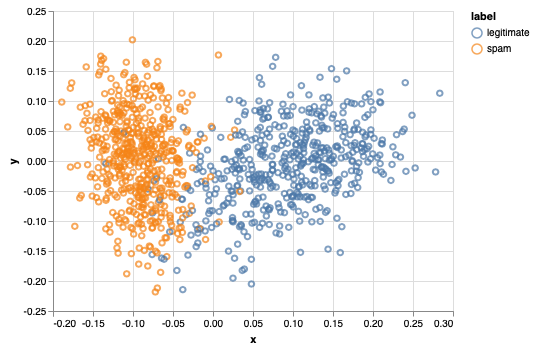

In [17]:
import altair as alt
alt.renderers.enable('notebook')

alt.Chart(plot_data.sample(1000)).encode(x="x", y="y", color="label").mark_point().interactive()

We want to be able to easily compute feature vectors using the hashing tf-idf workflow laid out above. A nice way to do this in Python is using the scikit learn Pipeline method. The pipeline method makes it easy to pass data through multiple transforms. In the next cell we set up our pipeline. We will then "pickle" our pipleine which is essentially saving it so that we can load it in later and re-implement the transformation, or pass new data through the same transform. 

In [18]:
from sklearn.feature_extraction.text import HashingVectorizer,TfidfTransformer
from sklearn.pipeline import Pipeline
import pickle, os

vect = HashingVectorizer(norm=None, token_pattern='(?u)\\b[A-Za-z]\\w+\\b', n_features=8192, alternate_sign = False)
tfidf = TfidfTransformer()

feat_pipeline = Pipeline([
    ('vect',vect),
    ('tfidf',tfidf)
])


filename = 'feature_pipeline.sav'
pickle.dump(feat_pipeline, open(filename, 'wb'))

We can then use the `fit_transform` method to apply the pipeline to our data frame. This produces a sparse matrix (only non zero entries are recorded). We convert this to a dense array using the `toarray()` function, then append the index and lables to aid readability. 

In [19]:
feature_vecs = feat_pipeline.fit_transform(df["text"]).toarray()
labled_vecs = pd.concat([df.reset_index()[["index", "label"]],
                                pd.DataFrame(feature_vecs)], axis=1)
labled_vecs.columns = labled_vecs.columns.astype(str)


In [20]:
labled_vecs.sample(10)

,index,label,0,1,2,3,4,5,6,7,...,8182,8183,8184,8185,8186,8187,8188,8189,8190,8191
75,75,legitimate,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36582,16582,spam,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11336,11336,legitimate,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6281,6281,legitimate,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29010,9010,spam,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4068,4068,legitimate,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19875,19875,legitimate,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37988,17988,spam,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14333,14333,legitimate,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19330,19330,legitimate,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We save the feature vectors to parquet file.

In [23]:
labled_vecs.to_parquet("data/features.parquet")

Now that we have a feature engineering approach, next step is to train a model.  Again, you have two choices for your next step:  [click here](04-model-logistic-regression.ipynb) for a model based on _logistic regression_, or [click here](04-model-random-forest.ipynb) for a model based on _ensembles of decision trees._